## Reading and writing image data

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import IPython.display as display

TensorFlow 2.x selected.


This is an end-to-end example of how to read and write image data using TFRecords. Using an image as input data, you will write the data as a TFRecord file, then read the file back and display the image.

Before proceeding we should get familiar with some basic components:

1. Protocol Buffers
2. tf.Example
3. TFRecords

## 1. Protocol Buffers

Protocol Buffers (Protobuf) is a method of serializing structured data. It is useful in developing programs to communicate with each other over a wire or for storing data. The method involves an interface description language that describes the structure of some data and a program that generates source code from that description for generating or parsing a stream of bytes that represents the structured data.

The design goals for Protocol Buffers emphasized simplicity and performance. In particular, it was designed to be smaller and faster than XML.

Google developed Protocol Buffers for use in their internal services. It is a binary encoding format that allows you to specify a schema for your data using a specification language. 

Data structures (called messages) and services are described in a proto definition file (.proto) and compiled with protoc. This compilation generates code that can be invoked by a sender or recipient of these data structures. 

Canonically, messages are serialized into a binary wire format which is compact, forward- and backward-compatible, but not self-describing (that is, there is no way to tell the names, meaning, or full datatypes of fields without an external specification).

A schema for a particular use of protocol buffers associates data types with field names, using integers to identify each field.

message Point { <br>
  required int32 x = 1; <br>
  required int32 y = 2; <br>
  optional string label = 3; <br>
} <br>

message Line { <br>
  required Point start = 1; <br>
  required Point end = 2; <br>
  optional string label = 3; <br>
} <br>

message Polyline { <br>
  repeated Point point = 1; <br>
  optional string label = 2; <br>
} <br>

The "Point" message defines two mandatory data items, x and y. The data item label is optional. Each data item has a tag. The tag is defined after the equal sign. For example, x has the tag 1.

As you can see, each field in the message definition has a unique number (tag). These numbers are used to identify your fields in the message binary format, and should not be changed once your message type is in use.

The "Line" and "Polyline" messages, which both use Point, demonstrate how composition works in Protocol Buffers. Polyline has a repeated field, which behaves like a vector.


## 2. tf.Example

The tf.Example message (or protobuf) is a flexible message type that represents a {"string": value} mapping. It is designed for use with TensorFlow and is used throughout the higher-level APIs such as TFX.

This notebook will demonstrate how to create, parse, and use the tf.Example message, and then serialize, write, and read tf.Example messages to and from .tfrecord files.

## Data types for tf.Example

Fundamentally, a tf.Example is a {"string": tf.train.Feature} mapping.

The tf.train.Feature message type can accept one of the following three types (See the .proto file for reference). Most other generic types can be coerced into one of these:

1. `tf.train.BytesList` (the following types can be coerced)

  - `string`
  - `byte`

1. `tf.train.FloatList` (the following types can be coerced)

  - `float` (`float32`)
  - `double` (`float64`)

1. `tf.train.Int64List` (the following types can be coerced)

  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

In order to convert a standard TensorFlow type to a tf.Example-compatible tf.train.Feature, you can use the shortcut functions below. Note that each function takes a scalar input value and returns a tf.train.Feature containing one of the three list types above



In [0]:
t = tf.constant([10])

In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
_int64_feature(t)

int64_list {
  value: 10
}

All proto messages can be serialized to a binary-string using the .SerializeToString method:

`feature.SerializeToString()`

In [7]:
_int64_feature(t).SerializeToString()

b'\x1a\x03\n\x01\n'

## Creating a tf.Example message

Suppose you want to create a `tf.Example` message from existing data. In practice, the dataset may come from anywhere, but the procedure of creating the `tf.Example` message from a single observation will be the same:

1. Within each observation, each value needs to be converted to a `tf.train.Feature` containing one of the 3 compatible types, using one of the functions above.

1. You create a map (dictionary) from the feature name string to the encoded feature value produced in #1.

1. The map produced in step 2 is converted to a `Features` message


Let us create a dataset using NumPy.

This dataset will have 4 features:

1. a boolean feature, False or True with equal probability
2. an integer feature uniformly randomly chosen from [0, 5]
3. a string feature generated from a string table by using the integer feature as an index
4. a float feature from a standard normal distribution

Consider a sample consisting of 10,000 independently and identically distributed observations from each of the above distributions:

In [0]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [10]:
print(feature0)
print(feature1)
print(feature2)
print(feature3)

[ True  True False ...  True  True False]
[1 1 2 ... 3 4 0]
[b'dog' b'dog' b'chicken' ... b'horse' b'goat' b'cat']
[-1.03346324  1.00227784  1.04103933 ...  0.12574208  0.46307068
 -0.77492272]


Each of these features can be coerced into a `tf.Example`-compatible type using one of `_bytes_feature`, `_float_feature`, `_int64_feature`. You can then create a `tf.Example` message from these encoded features:

In [0]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

For example, suppose you have a single observation from the dataset, <b>[False, 4, bytes('goat'), 0.9876]. </b>

You can create and print the tf.Example message for this observation using create_message(). 

Each single observation will be written as a Features message as per the above. 

In [0]:
serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

To decode the message use the `tf.train.Example.FromString` method.

In [0]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## 3. TFRecord

The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record just has a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data). You can easily create a TFRecord file using the tf.io.TFRecordWriter class:



In [0]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
  f.write(b"This is the first record")
  f.write(b"And this is the second record")

And you can then use a tf.data.TFRecordDataset to read one or more TFRecord
files:

In [12]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## Using TFRecord to read and write images



In [14]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')


16384/15477 [===============================] - 0s 0us/step


In [15]:
cat_in_snow

'/root/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg'

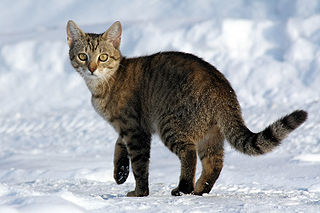

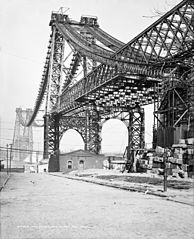

In [16]:
display.display(display.Image(cat_in_snow))
display.display(display.Image(williamsburg_bridge))


## Write the TFRecord file

First we, encode the features as types compatible with tf.Example. This stores the raw image string feature, as well as the height, width, depth, and arbitrary label feature. 

The latter is used when you write the file to distinguish between the cat image and the bridge image. Use 0 for the cat image, and 1 for the bridge image:

In [0]:
 image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [23]:
# This is an example, just for one image.
image_string = open(cat_in_snow, 'rb').read()
print(image_string)
label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x01\x02\x11!1\x03\x12AQ\x04

All of the features are now stored in the tf.Example message. Next, functionalize the code above and write the example messages to a file named images.tfrecords:

In [0]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [20]:
!ls

images.tfrecords  my_data.tfrecord  sample_data


## Read the TFRecord file

You now have the file—images.tfrecords—and can now iterate over the records in it to read back what you wrote. 

Given that in this example you will only reproduce the image, the only feature you will need is the raw image string. Extract it using the getters:

In [25]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

Recover the images from the TFRecord file:

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x01\x02\x11!1\x03\x12AQ\x04

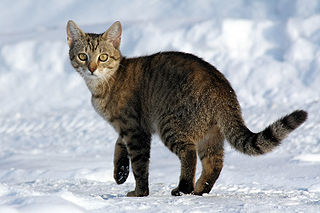

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x02\xee\x02\xee\x00\x00\xff\xfe\x00jFile source: http://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xc0\x00\x0b\x08\x00\xef\x00\xc2\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x00\x07\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\x00\t\xff\xc4\x00A\x10\x00\x02\x01\x03\x03\x02\x04\x05\x02\x04\x02\x08\x05\x05\x00\x00\x01\x02\x03\x04\x05\x11\x00\x12!\x061\x13"AQ\x07\x142aq\x81\x91\x15#B\xa1\x08\xc1$3Rbr\xb1\xd1\xe1\x16%\x82\x92\xf0CST\xa2\xc2\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xe9!\xce\xbc0;hs\xa0#>\xda\xf0\x1a\x1d\xa3B8\xed\xdbI\xcd40l\xf1\xe6\x8e"\xe7\t\xbd\x80\xdc}\x86t\xa2\x80s\xb5\x81\xfc\x1d\x17n\xbd\x8e5\xecq\xa2\xed\xc0\xc6\x8a\xc3EnF4]\x83F)\x91\xa0\xd9\x8

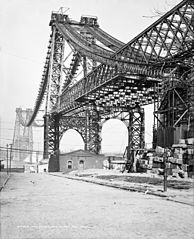

In [26]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  print(image_raw)
  display.display(display.Image(data=image_raw))